In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16		

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [2]:
x = vgg_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(136, activation='relu')(x) # Softmax for multiclass
transfer_model = tf.keras.Model(inputs=vgg_model.input, outputs=x)

In [3]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode='max', save_best_only=True, verbose=1)

In [4]:
learning_rate= 5e-5
transfer_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

In [5]:
import os
from libs.dp import Dataset

In [6]:
# checkpoint

checkpoint_path = "data/checkpoint_vgg16/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

transfer_model.save_weights(checkpoint_path.format(epoch=0))

In [7]:
IMG_RES = 256
HMS_RES = 64
NUM_LANDMARKS = 68
BATCH_SIZE = 16
DATASET_DIR = '../Data/300W_train/train.csv'

dataset = Dataset(IMG_RES, HMS_RES, NUM_LANDMARKS, DATASET_DIR)
# dataset_generator = 

Train dataset: ../Data/300W_train/train.csv
Train dataset is loaded. Shape: (3837, 2)


In [8]:
import numpy as np

In [9]:
tf_dataset = tf.data.Dataset.from_generator(dataset.gen_vgg16,
                                            output_types=(np.float32, np.float32),
                                            output_shapes=(
                                                [IMG_RES, IMG_RES, 3],
                                                [NUM_LANDMARKS * 2]),
                                            args=()).repeat().batch(BATCH_SIZE)

In [10]:
VAL_DIR = '../Data/300W/eval.csv'
val_dataset = Dataset(IMG_RES, HMS_RES, NUM_LANDMARKS, VAL_DIR)
val_tf_dataset = tf.data.Dataset.from_generator(dataset.gen_vgg16,
                                                output_types=(np.float32, np.float32),
                                                output_shapes=(
                                                    [IMG_RES, IMG_RES, 3],
                                                    [NUM_LANDMARKS * 2]),
                                                args=()).repeat().batch(BATCH_SIZE)


Train dataset: ../Data/300W/eval.csv
Train dataset is loaded. Shape: (600, 2)


In [11]:
hist = transfer_model.fit(tf_dataset.take(240), validation_data=val_tf_dataset.take(19), callbacks=[lr_reduce, cp_callback], epochs=120)

Epoch 1/120
240/240 [==============================] - 283s 1s/step - loss: 0.0652 - accuracy: 0.0557 - val_loss: 0.0184 - val_accuracy: 0.0329

Epoch 00001: saving model to data/checkpoint_vgg16/cp-0001.ckpt
Epoch 2/120
240/240 [==============================] - 279s 1s/step - loss: 0.0268 - accuracy: 0.1010 - val_loss: 0.0162 - val_accuracy: 0.1118

Epoch 00002: saving model to data/checkpoint_vgg16/cp-0002.ckpt
Epoch 3/120
240/240 [==============================] - 278s 1s/step - loss: 0.0186 - accuracy: 0.1198 - val_loss: 0.0134 - val_accuracy: 0.2007

Epoch 00003: saving model to data/checkpoint_vgg16/cp-0003.ckpt
Epoch 4/120
240/240 [==============================] - 279s 1s/step - loss: 0.0156 - accuracy: 0.1154 - val_loss: 0.0098 - val_accuracy: 0.1941

Epoch 00004: saving model to data/checkpoint_vgg16/cp-0004.ckpt
Epoch 5/120
240/240 [==============================] - 279s 1s/step - loss: 0.0144 - accuracy: 0.1464 - val_loss: 0.0097 - val_accuracy: 0.2664

Epoch 00005: saving

In [12]:
transfer_model.save('model_vgg')

INFO:tensorflow:Assets written to: model_vgg/assets


In [13]:
transfer_model.save('data/vgg16.h5')

In [14]:
import matplotlib.pyplot as plt

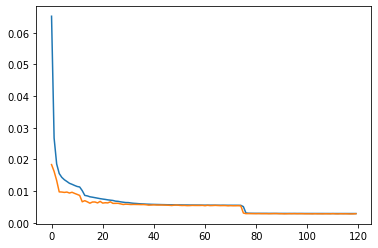

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [82]:
val_dataset = Dataset(IMG_RES, HMS_RES, NUM_LANDMARKS, VAL_DIR)

Train dataset: ../Data/300W/eval.csv
Train dataset is loaded. Shape: (600, 2)


In [78]:
def l2_distance(a, b):
    d = a - b
    error = 0.
    for i, p in enumerate(d):
        error += np.sqrt(p[0] ** 2 + p[1] ** 2)
    error = error / d.shape[0]
    return error

In [81]:
from tqdm import tqdm

In [83]:
error = 0.
for img, kps in tqdm(val_dataset.gen_vgg16(), desc='Evaluation'):
    pred = transfer_model.predict(np.array([img]))
    pred = np.reshape(pred, pred.shape[-1]) * 256
    pred_kps = np.zeros((int(pred.shape[0] / 2), 2))
    for i in range(pred_kps.shape[0]):
        pred_kps[i] = pred[i*2:i*2+2]
    # plt.imshow(img)
    # plt.scatter(pred_kps[:,0], pred_kps[:,1])
    orig_kps = np.zeros((int(pred.shape[0] / 2), 2))
    for i in range(orig_kps.shape[0]):
        orig_kps[i] = kps[i*2:i*2+2] * 256
    # plt.scatter(orig_kps[:,0], orig_kps[:,1])
    error += l2_distance(orig_kps, pred_kps)
error = error / 600
print(error)

Evaluation: 600it [01:30,  6.67it/s]
